In [1]:
!pip install gekko

     |████████████████████████████████| 12.4 MB 3.8 MB/s eta 0:00:01


Here's a [link](https://apmonitor.com/do/index.php/Main/ModelFormulation) the this homework's webpage. Basically, we are simulated fluid heights over 4 interconnected lakes (i.e. tanks) in Utah. There are several ways to do this. I'll start by using GEKKO.

Here's a list of parameters for this problem:

```
 Outflow River Rates (km3/yr) with height in meters
 Vflow_out1 = 0.030 sqrt(h1) 
 Vflow_out2 = 0.015 sqrt(h2) 
 Vflow_out3 = 0.060 sqrt(h3)
 Vflow_out4 = 0

 Evaporation Rates (km3/yr)
 Vevap = 0.5e-5 * Area, for salt water (Great Salt Lake)
 Vevap = 1e-5 * Area, for fresh water (all others)

 Inflow Rates (km3/yr)
 Vflow_in1 = 0.13 (June-Feb), 0.21 (Mar-May)
 Vflow_in2 = Vflow_out1
 Vflow_in3 = Vflow_out2
 Vflow_in4 = Vflow_out3

 Usage Requirements (km3/yr)
 Vuse1 = 0.03
 Vuse2 = 0.05
 Vuse3 = 0.02
 Vuse4 = 0.00

 Area of Reservoir / Lake (km2)
 A1 = 13.4
 A2 = 12.0
 A3 = 384.5
 A4 = 4400

 Initial Volume of Reservoir / Lake (km3)
 V1 = 0.26
 V2 = 0.18
 V3 = 0.68
 V4 = 22.0
 ```

In general, this is going to be a system of 4 first-order coupled ODEs with 4 state variables representing the height of each of the reservoirs. 

We can start with a mass balance of a single reservoir (tank, since we are assuming areas are constant as well):

$$ \frac{dm}{dt} = \dot{m}_{\mathrm{in}} - \dot{m}_{\mathrm{out}} $$

Since $m = \rho V \implies \dot{m} = \rho \dot{V} = \rho A \dot{h}$ (assuming constant density of water), we can rewrite the above equation as:

$$ \rho A \frac{dh}{dt} = \rho \dot{V}_{\mathrm{in}} - \rho \dot{V}_{\mathrm{out}} $$

or 

$$ A \frac{dh}{dt} =  \dot{V}_{\mathrm{in}} -  \dot{V}_{\mathrm{out}} $$

The table above tells us that there is one source of volumtric flow for each tank and several sources of outflow for each tank (usage, outflow, and evaporation).

So the final ODE for a single tank is going to look something like this:

``` A * hdot = Vflow_in - k * sqrt(h) - c * A - Vuse ```


In [42]:
from gekko import GEKKO
import numpy as np

#constant parameters
areas = np.array([13.4,12.0,384.5,4400])

#outflow coefficients/constants
c = np.array([.03, .015,.06, 0])
Vuse = np.array([.03,.05,.02,.00])

#initial conditions
V0 = np.array([.26,.18,.68,22])
h0 = 1000 * V0 /areas

#initial outflow rates
Vout0 = c * np.sqrt(h0)

#time varying inflow rate into first tank
vin_first = [0.13,0.13,0.21,0.21,0.21,0.13,\
       0.13,0.13,0.13,0.13,0.13,0.13]

Vin = np.zeros(4)


In [43]:
#GEKKO STUFF

m = GEKKO()
# m.time = np.linspace(0,1,12) # 0 to 1 year with 13 values?
m.time = np.linspace(0,1,12,endpoint=False) #needs to be in year because of units of data given.
#load constant params
params = m.Array(m.Const, 4, value=0)
params[0].value = c[0]
params[1].value = c[1]
params[2].value = c[2]
params[3].value = c[3]

evap_coeff = m.Array(m.Param,4,value=1e-5)
evap_coeff[-1].value = .5e-5

#input flow rates
Vin = [0,0,0,0]
Vin[0] = m.Param(value=vin_first)

#load all areas as gekko params
A = [m.Param(value=a) for a in areas]

#load gekko time variables (volume, height, outflow rates)
V = [m.Var(value=v) for v in V0]
h = [m.Var(value=i) for i in h0]
Vout = [m.Var(value=j) for j in Vout0]

#load 'intermediate' variables into gekko model. Kinda like kinematic relationships
Vin[-3:] = [m.Intermediate(Vout[i]) for i in range(3)] #link output to each successive tank's input
Vevap = [m.Intermediate(evap_coeff[i] * A[i]) for i in range(4)]

#Equations
m.Equations([V[i].dt() == \
             Vin[i] - Vout[i] - Vevap[i] - Vuse[i] \
             for i in range(4)])
m.Equations([1000*V[i] == h[i]*A[i] for i in range(4)])
m.Equations([Vout[i]**2 == c[i]**2 * h[i] for i in range(4)])



apm 10.32.114.116_gk_model14 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            4
   Variables    :           21
   Intermediates:            7
   Connections  :            0
   Equations    :           19
   Residuals    :           12
 
 Number of state variables:            176
 Number of total equations: -          176
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

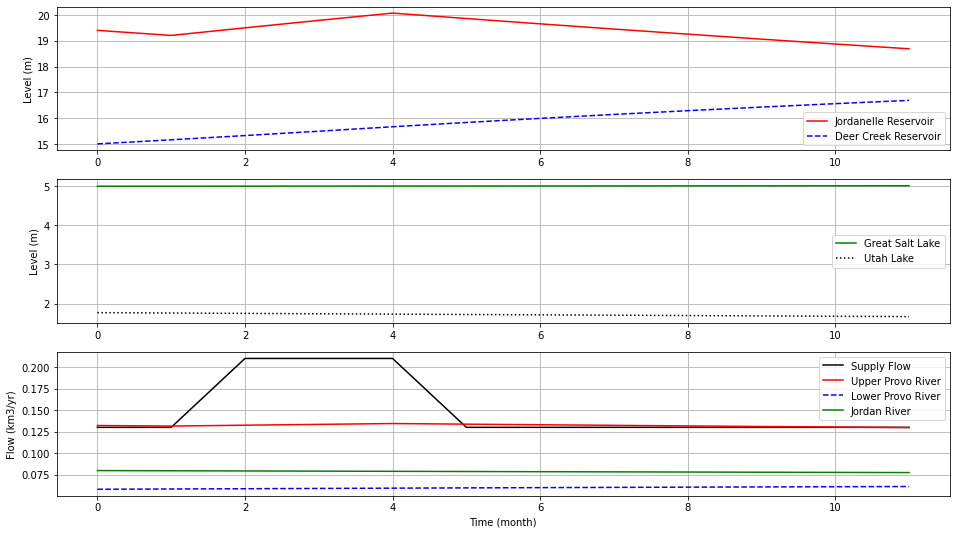

In [44]:

#Set to simulation mode
m.options.imode = 4

#Solve
m.solve()

# %% Plot results
time = [x * 12 for x in m.time] #convert times from years to months

# plot results
import matplotlib.pyplot as plt
plt.figure(1,figsize=(16,9))

plt.subplot(311)
plt.plot(time,h[0].value,'r-')
plt.plot(time,h[1].value,'b--')
plt.grid(True)
plt.ylabel('Level (m)')
plt.legend(['Jordanelle Reservoir','Deer Creek Reservoir'])

plt.subplot(312)
plt.plot(time,h[3].value,'g-')
plt.plot(time,h[2].value,'k:')
plt.grid(True)
plt.ylabel('Level (m)')
plt.legend(['Great Salt Lake','Utah Lake'])

plt.subplot(313)
plt.plot(time,Vin[0].value,'k-')
plt.plot(time,Vout[0].value,'r-')
plt.plot(time,Vout[1].value,'b--')
plt.plot(time,Vout[2].value,'g-')
plt.grid(True)
plt.xlabel('Time (month)')
plt.ylabel('Flow (km3/yr)')
plt.legend(['Supply Flow','Upper Provo River', \
            'Lower Provo River','Jordan River'])
plt.show()
